In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.votable import parse_single_table
import numba
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw

import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm import tqdm
%matplotlib inline

In [76]:
path_plot = '../figures/'
path_isochrones = '../data/isochrones/'
path_pandas= '../data/pandas/'
mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']

In [64]:
from numba import njit

@njit(nopython=True)
def interp_nb(xvals, x, y):
    return np.interp(xvals, x, y)

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [286]:
def read_roman_isochrones():
    from astropy.io import ascii
    return ascii.read(path_isochrones+'/roman_isochrones_vega.txt').to_pandas()

def combined_isochrones():
    from astropy.io import ascii
    fls= glob.glob(path_isochrones+'/*.txt')
    dfs=[]
    for f in fls:
        dfs.append(ascii.read(f).to_pandas())
    comb_isos=pd.concat(dfs).reset_index(drop=True)
    return comb_isos    

def sample_kroupa_imf(nsample, massrange=[0.1, 10]):
    m0=sample_from_powerlaw(-0.3, xmin=0.03, xmax= 0.08, nsample=int(nsample))
    m1=sample_from_powerlaw(-1.3, xmin=0.08, xmax= 0.5,  nsample=int(nsample))
    m2=sample_from_powerlaw(-2.3, xmin=0.5, xmax= 100 , nsample=int(nsample))
    m= np.concatenate([m0, m1, m2]).flatten()
    mask= np.logical_and(m> massrange[0], m< massrange[1])
    masses= np.random.choice(m[mask], int(nsample))
    return masses

def sample_metallicities(nsample, met_range, rgc):
    #draw metallicities from underlying distribution
    data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas().FeH_phot.values
    #just return random and replace (no worries about smoothness of CDF)
    data=data[np.logical_and(data>met_range[0], data<met_range[1])]
    return np.random.choice(data, nsample, replace=True)


def interpolate_isochrones(mets, mass_range, age_range, nsample):
    isos= combined_isochrones()
    logage_range=np.log10(age_range)
    met_range=[np.nanmin(mets), np.nanmax(mets)]
    limits=np.concatenate([mass_range, logage_range, met_range])
    
    query='(Mini > {} & Mini <{}) & (logAge > {} & logAge <  {}) & (MH > {} & MH < {})'.format(*limits)
    isos=isos.query(query)

    nisos_=len(np.unique(isos.MH))*len(np.unique(isos.logAge))

    masses=sample_kroupa_imf(nsample, massrange=mass_range)
    
    ages= np.unique(isos.logAge)
    ages= ages[~np.isnan(ages)]
    
    @numba.jit
    def interpolate_one_iso(masses, mets, age):
        dfn=isos.query('logAge=={}'.format(age))
        interpolated={}
        for k in mag_keys:
            x= np.log10(dfn.Mini.values)
            y= dfn.MH.values
            z= dfn[k].values
            nans=np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(z)]) #remove whiye dwarfs
            x=x[~nans]
            y=y[~nans]
            z=z[~nans]
            if len(x) ==0 or len(y)==0 or len(z)==0:
                pass
            else:
                interpolated.update({k:griddata((x, y), z, (np.log10(masses), mets),
                                            fill_value=np.nan, rescale=True,  \
                                            method='nearest')})
        return interpolated
    
    final_df=[]
    for logAge in tqdm(ages):
            xvs=interpolate_one_iso(masses, mets, logAge)
            vs=pd.DataFrame.from_records(xvs)
            vs['logAge']=logAge
            vs['MH']=mets
            vs['Mini']=masses
            final_df.append(vs)
            
    return  pd.concat(final_df).sample(int(nsample), replace=True).reset_index(drop=True)


In [258]:
rgc='10_20'
data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
rgc='30_40'
data1=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
rgc='50_60'
data2=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()

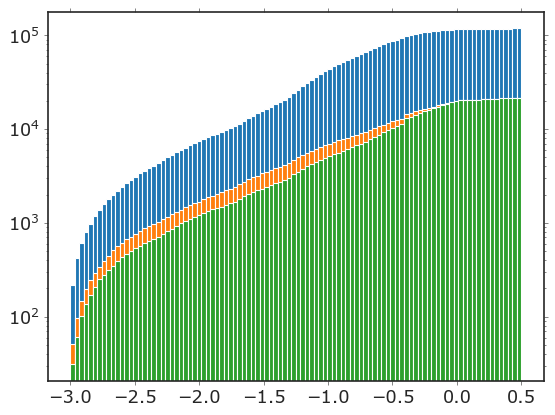

In [259]:
fig, ax=plt.subplots()
_= ax.hist(data.FeH_phot, range=[-3, 0.5], bins=100, cumulative=True,log=True)

#fig, ax=plt.subplots()

_= ax.hist(data1.FeH_phot, range=[-3, 0.5], bins=100, cumulative=True, log=True)

#fig, ax=plt.subplots()
_= ax.hist(data2.FeH_phot, range=[-3, 0.5], bins=100,  cumulative=True, log=True)

In [260]:
df=combined_isochrones()

In [261]:
df.Mini.min(), df.Mini.max()

(0.0900000036, 67.5720901489)

In [262]:
10**(10.15)

14125375446.227554

In [263]:
masses=np.random.uniform(0.09, 67, 10000)
mets=np.random.uniform(-2, 0.5, 10000)
ages= np.unique(df.logAge)
ages= ages[~np.isnan(ages)]
isos=df
mags= pd.DataFrame(interpolate_one_iso(masses, mets, ages[-1]))

[(40.0, -10.0), (-5.0, 10.0), Text(0.5, 0, 'R-Z'), Text(0, 0.5, 'Z')]

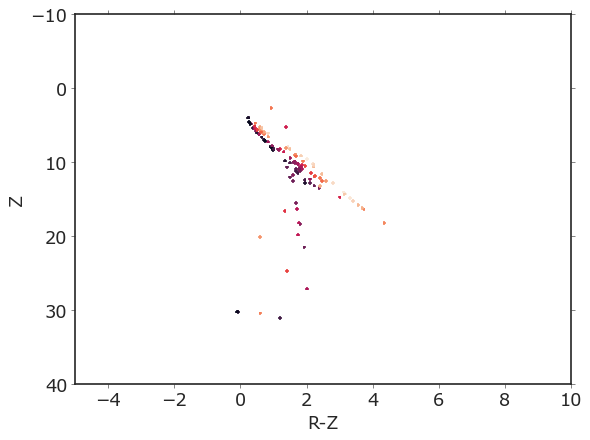

In [264]:
fig, ax=plt.subplots()
ax.scatter(mags.gmag-mags.imag, mags.gmag, c= mets, s=10, marker='+')
plt.colorbar(c)
ax.set(ylim=[40, -10], xlim=[-5, 10], xlabel='R-Z', ylabel='Z')

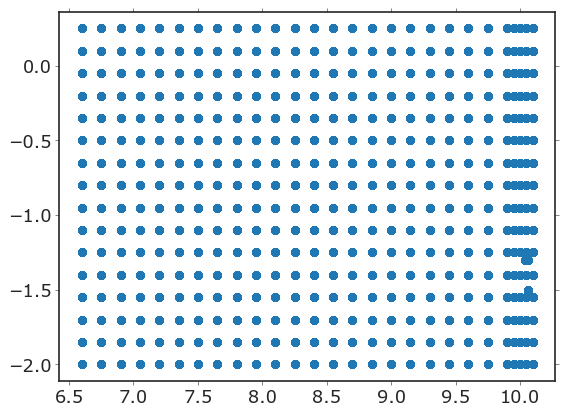

In [265]:
fig, ax=plt.subplots()
ax.scatter(df.logAge, df.MH)

In [266]:
df.columns

Index(['Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label',
       'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X',
       'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'u*mag', 'gmag',
       'rmag', 'imag', 'zmag', 'MH', 'logAge', 'int_IMF', 'period2', 'period3',
       'period4', 'umag', 'F062mag', 'F087mag', 'F106mag', 'F129mag',
       'F158mag', 'F184mag', 'F146mag', 'F213mag', 'SNprismmag',
       'Grism_1stOrdermag', 'Grism_0thOrdermag', 'F149mag', 'R062mag',
       'Z087mag', 'Y106mag', 'J129mag', 'H158mag', 'W149mag'],
      dtype='object')

In [268]:
isos=df

[(30.0, 10.0), (-5.0, 10.0), Text(0.5, 0, 'R-Z'), Text(0, 0.5, 'Z')]

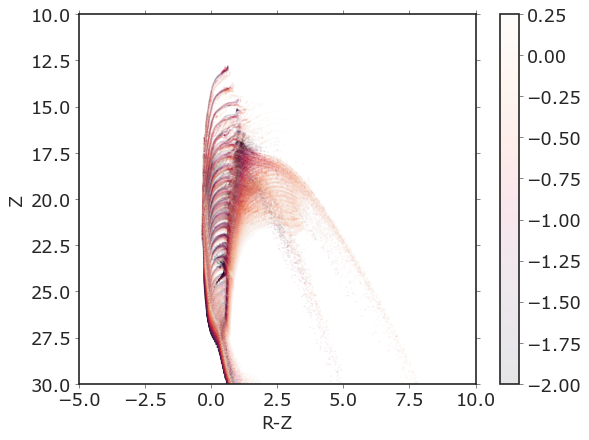

In [269]:
fig, ax=plt.subplots()
c=ax.scatter(df.F062mag-df.F087mag, df.F087mag+24.4, s=0.1, alpha=0.1, c=df.MH)
plt.colorbar(c)
ax.set(ylim=[30, 10], xlim=[-5, 10], xlabel='R-Z', ylabel='Z')

In [270]:
df.MH.max()

0.25

In [281]:
#mets=np.random.uniform(*met_range, int(nsample/nisos_))--> do not use uniform metallicities
nsample=1000
mets= sample_metallicities(nsample, [-2, 0.25], '10_20')
    

In [ ]:
len(mets)

In [287]:
vals=interpolate_isochrones(mets,(0.1, 120), (0.01e9, 13e9), nsample)

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 16.44it/s]


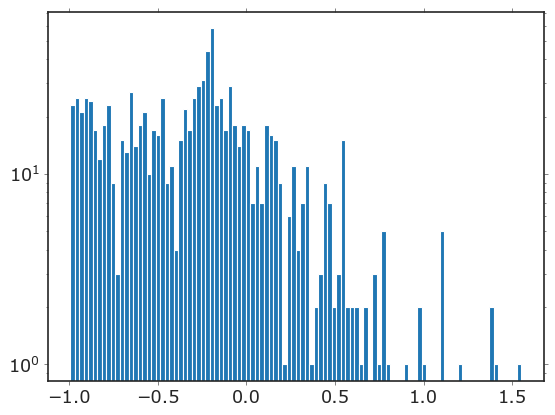

In [296]:
fig, ax=plt.subplots()
_= ax.hist(np.log10(vals.Mini), log=True, bins=100)

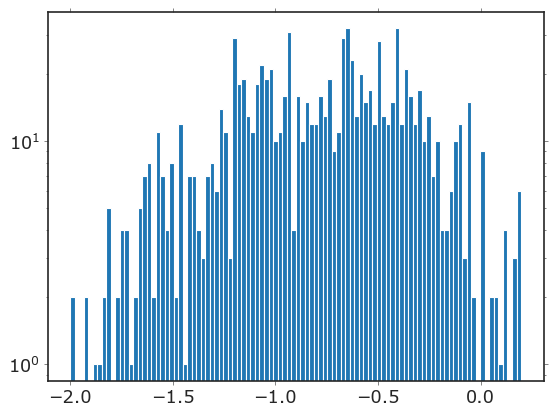

In [299]:
fig, ax=plt.subplots()
_= ax.hist(vals.MH, log=True, bins=100)

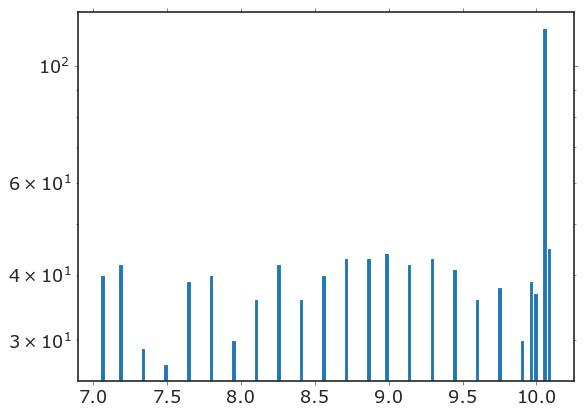

In [300]:
fig, ax=plt.subplots()
_= ax.hist(vals.logAge, log=True, bins=100)

[(30.0, 10.0), (-5.0, 10.0), Text(0.5, 0, 'R-Z'), Text(0, 0.5, 'Z')]

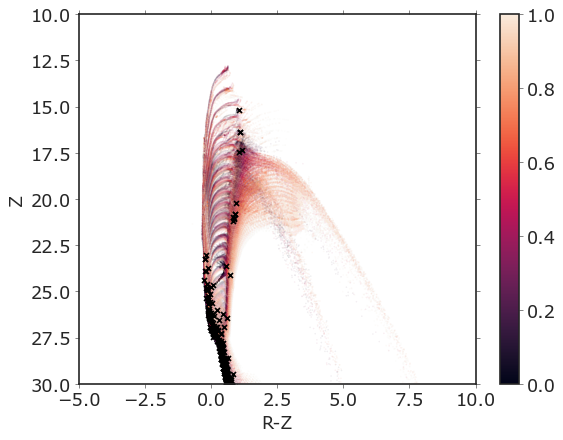

In [289]:
fig, ax=plt.subplots()

c=ax.scatter(df.F062mag-df.F087mag, df.F087mag+24.4, s=0.1, alpha=0.1, c=df.MH)
c=ax.scatter(vals.F062mag-vals.F087mag, vals.F087mag+24.4, s=20, alpha=1, c='k', marker='x')
plt.colorbar(c)
ax.set(ylim=[30, 10], xlim=[-5, 10], xlabel='R-Z', ylabel='Z')

In [ ]:
fig, ax=plt.subplots()


In [ ]:
fig, ax=plt.subplots()
ax.hist(vals.MH)

In [ ]:
vals.columns

In [ ]:
#interpolate in metallicities --> not uniform 
mass and metallicity | age --> mag